# Dynamic Weight Majority Algorithm

This notebook is an implementation of the DNW algorithm with Naive-Bayes models <br />

First I present the algorithm, I explain its steps and then i present the implementation with evalutation results.<br />
At the same time I create the initial test dataset to use.<br />


## Presentation of the Algorithm: 

### Inputs: 

A) {x,y}: Feature vectors and class labels <br />
B) c : Number of classes <br />
C) β : factor for decreasing weights<br />
D) θ : threshold for deleting experts<br />
E) p : period for expert removal <br />

### Outputs: <br />

A) Λ : global predictions

## Algorithm : 

**START** <br />

m ← 1       &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  ( m = number of experts )<br />
e1 ← Create_New_Expert() <br />
wm ← 1   &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;( wm = weight of expert m ) <br />  <br />

**FOR** i **OVER** n : ( n = number of feature vectors ) <br /> 
&emsp;σ ← 0 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;( σ = sum of weighted predictions for each class) <br /> <br /> 
&emsp;**FOR** j **OVER** m :    <br /> 
&emsp;&emsp; λ ← Predict( ej , xi ) &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; ( expert ej will try to classify feature xi) <br /> 
&emsp;&emsp;**IF (** λ != yi **AND** i **MOD** p = 0 **) THEN** : <br /> 
&emsp;&emsp;&emsp;wj ← β * wj  <br />
&emsp;&emsp;σλ ← σλ +wj <br />
&emsp;Λ ← argmaxj σj <br /><br />

&emsp;**IF (** i **MOD** p = 0 **) THEN**: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; ( check if need to remove or add experts ) <br/>
&emsp;&emsp;w ← Normalize-Weights(w) <br/>
&emsp;&emsp;{e,w} ← Remove-Experts({e,w},θ) <br/>
&emsp;&emsp;**IF (** Λ != yi **) THEN** : <br/>
&emsp;&emsp;&emsp;m ← m+1 <br/>
&emsp;&emsp;&emsp;em ← Create-New-Expert() <br/>
&emsp;&emsp;&emsp;wm ← 1<br/><br/>

&emsp;**FOR** j **OVER** m :    <br /> 
&emsp;&emsp;e j ← Train(ej,xi,yi)<br/>
&emsp;**OUTPUT** Λ <br /> 

**END** <br />


## Important Functions:



In [1]:
import pandas as pd
import numpy as np
from random import seed
import random
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
import matplotlib.pyplot as plt

from datetime import datetime

### Dataset Creation: 

In [3]:
def generateDataset(length):
    ######################################################
    #                  Stagger Dataset                   #
    #              colums: color,shape,size              #
    #              return: pandas dataframe              #
    ######################################################
    #color = ["green","blue","red"]
    #shape = ["triangle","circle","rectangle"]
    #size = ["small","medium","large"]
    
    color = [0,1,2]
    shape = [0,1,2]
    size = [0,1,2]
    seed(datetime.now())
    
    dataset = pd.DataFrame(columns=['color',"shape","size"]) #index= range(length)
   
    for i in range(length):
        dataset.loc[i,'color'] = random.choice(color)
        dataset.loc[i,'shape'] = random.choice(shape)
        dataset.loc[i,'size'] = random.choice(size)
                
       
    return dataset
    

In [4]:
def generateLabels(length):
    
    label = np.zeros([120,length])
    dataset = []
    for t in range(120):
        dataset.append(generateDataset(length))
        for i in range(length):
            if t > 80 :
                if  dataset[t].loc[i,'size'] == 1 or dataset[t].loc[i,'size'] == 2: # size = medium or large
                    label[t,i] = 1
            if t < 80 and t > 40 :
                if  dataset[t].loc[i,'shape'] == 1 or dataset[t].loc[i,'color'] == 0: # shape = circle or color = green
                    label[t,i] = 1           
            if t < 40 :
                if  dataset[t].loc[i,'color'] == 2 and dataset[t].loc[i,'size'] == 0: # color = red and size = small
                    label[t,i] = 1
    
    return dataset,label

In [5]:
def createdataset(length):
    dt = [None]*120
    dataset,labels = generateLabels(length)
    for i in range(len(dataset)):
      dataset[i].loc[:,"color"] = pd.Categorical(dataset[i].loc[:,"color"])
      dataset[i].loc[:,"shape"] = pd.Categorical(dataset[i].loc[:,"shape"])
      dataset[i].loc[:,"size"] = pd.Categorical(dataset[i].loc[:,"size"])
      a = pd.get_dummies(dataset[i].loc[:,"color"], prefix = 'color')
      b = pd.get_dummies(dataset[i].loc[:,"shape"], prefix = 'shape')
      c = pd.get_dummies(dataset[i].loc[:,"size"], prefix = 'size')
      dt[i] = pd.concat([a, b, c ], axis=1)
    return dt,labels

### DMW functions:

In [6]:
def create_new_expert():
    model = BernoulliNB()
    w = 1 
    return model,w 

In [7]:
def predict(expert,feature):
    predicted = expert.predict(feature) 
    return predicted

In [8]:
def train(expert,feature,label,c):
    expert.partial_fit([feature],[label],np.unique(c))

In [9]:
def remove_experts(Ex,W,th):
    toBeRemoved = []
    
    for i in range(len(W)):
        if W[i] <= th :
            toBeRemoved.append(i)
    if len(toBeRemoved) != len(Ex):        
      for i in toBeRemoved:
              Ex.pop(i)
              W.pop(i)  

In [24]:
def normalize_rows(w):
    """
    
    """
    
    maximum = np.max(w)
    for i in range(len(w)):
      w[i] = w[i] / maximum
    
    return w

In [60]:
def DMW(dataset,label,c,b,th,p):
    ######################################################
    #               Dynamic Weight Majority              #
    #                                                    #
    ######################################################
    
    # List to return
    acc = []
    NoE = []
    # Initialization
    m = 1
    Ex = []
    W = []
    e,w = create_new_expert()
    e.partial_fit([[0,0,0,0,0,0,0,0,0]],[[0]],np.unique(c))
    Ex.append(e)
    W.append(w)
    
    # Beginning of loop over the dataset
    
    for i in range(len(dataset)):
        print("Timestep: {}".format(i))
        print(dataset[i].loc[0,:])
        print()
        print(label[i,0])
        s = [0] * len(c)
    
    # Test with one sample  
        for e in range(len(Ex)):
            l = int(predict(Ex[e],[dataset[i].loc[0,:]]))
            
            if l != label[i,0] and i % p == 0 :
                W[e] = W[e]*b
            s[l] = s[l] + W[e]
        
        
        sampleResult = np.argmax(s)   
        print("Overal prediction : {}".format(sampleResult))
    # Test with the rest of the samples
        print("All the labels: {}".format(label[i,1:]))
        overalPred = np.zeros(len(label[i,1:]))
        predictions = np.zeros((len(label[i,1:]),2))
        for e in range(len(Ex)): 
          for j in range(1,len(dataset[i].loc[1:,:])):
            t = int(predict(Ex[e],[dataset[i].loc[j,:]]))
            predictions[j,t] += W[e]
        for j in range(len(overalPred)):
          overalPred[j] = np.argmax(predictions[j,:])
        print("Predictions: {}".format(overalPred))
        acc.append(metrics.accuracy_score(label[i,1:], overalPred))  
        print(metrics.accuracy_score(label[i,1:], overalPred))
        
        
        
        
        
     #   for j in range(len(dataset[i].loc[1:,:])):
     #       s1 = [0]* len(c)
     #       for e in range(len(Ex)):
     #           temPred = int(predict(Ex[e],[dataset[i].loc[j,:]]))
     #           s1[temPred] += W[e]
     #       prediction = max(s1)
     #       prediction = s1.index(prediction)
     #       overalPred.append(prediction)
     #   acc.append(metrics.accuracy_score(label[i,1:], overalPred)) 
    # Normalize and remove or create experts
    
        if i % p == 0 :
            print("weights of experts before: {}".format(W))
            W = normalize_rows(W)
            #W = W.tolist()
            print("weights of experts after: {}".format(W))

            remove_experts(Ex,W,th) 
            if sampleResult != label[i,0]:
                print("Adding expert")
                m = m+1
                e,x = create_new_expert()
                Ex.append(e)
                W.append(w)
        #print("Number of Experts:  "+ str(len(Ex)))
        NoE.append(len(Ex))

        
    # Train with the rest of the samples
        
        for e in Ex:
            #train(e,dataset[i].loc[0,:],label[i,0],c)
            e.partial_fit([dataset[i].loc[0,:]],[label[i,0]],c)
        
        
                 
    return acc,NoE

Timestep: 0
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.8484848484848485
weights of experts before: [0.5]
weights of experts after: [1.0]
Adding expert
Timestep: 1
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    1

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.8686868686868687
weights of experts before: [1.0, 0.25, 1.0]
weights of experts after: [1.0, 0.25, 1.0]
Timestep: 11
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Predictions: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0.]
0.8181818181818182
weights of experts before: [1.0, 0.25, 1.0, 0.5]
weights of experts after: [1.0, 0.25, 1.0, 0.5]
Timestep: 21
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 1.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0.]
0.8585858585858586
weights of experts before: [1.0, 0.25, 0.5, 0.25]
weights of experts after: [1.0, 0.25, 0.5, 0.25]
Timestep: 31
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.9393939393939394
weights of experts before: [1.0, 0.25, 0.5, 0.125]
weights of experts after: [1.0, 0.25, 0.5, 0.125]
Timestep: 41
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 0
All the labels: [1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.5555555555555556
weights of experts before: [1.0, 0.25, 0.5, 0.125, 0.25, 0.5]
weights of experts after: [1.0, 0.25, 0.5, 0.125, 0.25, 0.5]
Timestep: 50
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 1.]
Predictions: [0. 0. 0. 0. 

Predictions: [0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1.]
0.5454545454545454
weights of experts before: [0.03125, 0.0078125, 0.015625, 0.0078125, 0.125, 0.125, 1.0, 1.0, 0.25]
weights of experts after: [0.03125, 0.0078125, 0.015625, 0.0078125, 0.125, 0.125, 1.0, 1.0, 0.25]
Timestep: 59
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.

Predictions: [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0.]
0.4444444444444444
weights of experts before: [0.03125, 0.125, 0.25, 0.03125, 1.0, 1.0, 0.5]
weights of experts after: [0.03125, 0.125, 0.25, 0.03125, 1.0, 1.0, 0.5]
Timestep: 68
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0.]
Pr

Predictions: [0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 1.]
0.45454545454545453
weights of experts before: [0.015625, 0.25, 1.0, 0.0625, 0.5, 0.5, 0.5, 0.5, 0.5]
weights of experts after: [0.015625, 0.25, 1.0, 0.0625, 0.5, 0.5, 0.5, 0.5, 0.5]
Timestep: 77
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.

Predictions: [0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 1.]
0.5555555555555556
weights of experts before: [0.125, 0.5, 0.0625, 0.25, 0.25, 0.25, 0.25, 0.25, 1.0, 0.5]
weights of experts after: [0.125, 0.5, 0.0625, 0.25, 0.25, 0.25, 0.25, 0.25, 1.0, 0.5]
Timestep: 86
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 

Predictions: [0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 1.]
0.5252525252525253
weights of experts before: [0.015625, 0.0625, 0.0078125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 1.0, 0.5, 0.5]
weights of experts after: [0.015625, 0.0625, 0.0078125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 1.0, 0.5, 0.5]
Timestep: 94
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.


Predictions: [0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 1.]
0.5151515151515151
weights of experts before: [0.015625, 0.015625, 1.0, 0.5, 0.5]
weights of experts after: [0.015625, 0.015625, 1.0, 0.5, 0.5]
Timestep: 102
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 0.]
Predictions: [0. 0. 1. 

Predictions: [0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1.]
0.5353535353535354
weights of experts before: [0.015625, 0.015625, 1.0, 0.5, 0.5]
weights of experts after: [0.015625, 0.015625, 1.0, 0.5, 0.5]
Timestep: 112
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1.]
Predictions: [0. 1. 1. 

<function matplotlib.pyplot.show(*args, **kw)>

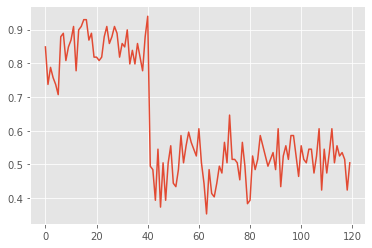

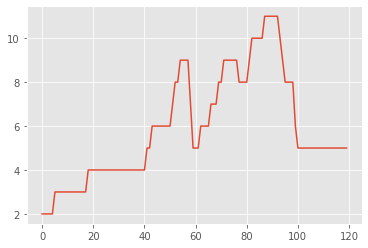

In [61]:
c = [0,1]
dataset,labels = createdataset(100)
acc,NoE = DMW(dataset,labels,c,0.5,0.01,1)
plt.style.use("ggplot")
plt.figure(0)
plt.plot(np.arange(0, len(acc)), acc,label="acc")
plt.figure(1)
plt.plot(np.arange(0, len(NoE)), NoE,label="acc")
plt.show

In [59]:
Acc = list()
NoL = list()
c = [0,1]
for z in range(10):
  print("Iteration : {}".format(z))
  dataset,labels = createdataset(100)
  acc,NoE = DMW(dataset,labels,c,0.5,0.01,1)
  Acc.append(acc)
  NoL.append(NoE)
print("Done")  
Acc = np.asarray(Acc)
Acc.shape[1]
NoL = np.asarray(NoL)
Accu = np.zeros((120))
NoLu = np.zeros((120))
for i in range(Acc.shape[0]):
  Accu[i] = np.mean(Acc[:,i])
  NoLu[i] = np.mean(NoL[:,i])
plt.style.use("ggplot")
plt.figure(0)
plt.plot(np.arange(0, len(Accu)), Accu,label="acc")
plt.figure(1)
plt.plot(np.arange(0, len(NoLu)), NoLu,label="acc")
plt.show

Iteration : 0
Timestep: 0
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 0
All the labels: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.8787878787878788
weights of experts before: [0.5]
weights of experts after: [1.0]
Adding expert
Timestep: 1
color_0.0    0
color_1.0    0
color_2.0    1


0.8080808080808081
weights of experts before: [1.0, 0.5, 1.0]
weights of experts after: [1.0, 0.5, 1.0]
Timestep: 10
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0.]
0.8080808080808081
weights of experts before: [1.0, 0.5, 1.0]
we

0.8080808080808081
weights of experts before: [1.0, 0.5, 1.0]
weights of experts after: [1.0, 0.5, 1.0]
Timestep: 21
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.898989898989899
weights of experts before: [1.0, 0.5, 1.0]
wei

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0.]
0.7878787878787878
weights of experts before: [1.0, 0.5, 0.5, 0.125]
weights of experts after: [1.0, 0.5, 0.5, 0.125]
Timestep: 32
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0.]
0.43434343434343436
weights of experts before: [1.0, 0.5, 0.5, 0.25, 0.25]
weights of experts after: [1.0, 0.5, 0.5, 0.25, 0.25]
Timestep: 42
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

1.0
Overal prediction : 0
All the labels: [1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 1. 0. 0. 0. 0. 0

Predictions: [1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 1.]
0.46464646464646464
weights of experts before: [0.03125, 0.015625, 0.015625, 0.0625, 0.0625, 0.5, 0.5, 0.25]
weights of experts after: [0.0625, 0.03125, 0.03125, 0.125, 0.125, 1.0, 1.0, 0.5]
Adding expert
Timestep: 51
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1

Predictions: [1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0.]
0.5757575757575758
weights of experts before: [1.0, 0.25, 0.5, 0.25, 0.5]
weights of experts after: [1.0, 0.25, 0.5, 0.25, 0.5]
Timestep: 61
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 0.]
Predictions: [0. 0. 0. 0. 1. 1. 0. 1. 1.

Predictions: [1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0.]
0.5151515151515151
weights of experts before: [1.0, 0.25, 0.5, 0.0625, 0.0625]
weights of experts after: [1.0, 0.25, 0.5, 0.0625, 0.0625]
Timestep: 71
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0.]
Predictions: [0. 1. 0. 0. 0. 1

Predictions: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1.]
0.41414141414141414
weights of experts before: [0.5, 0.125, 0.25, 0.015625, 0.015625]
weights of experts after: [1.0, 0.25, 0.5, 0.03125, 0.03125]
Adding expert
Timestep: 81
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predict

Predictions: [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 1.]
0.5252525252525253
weights of experts before: [0.25, 0.0625, 0.125, 0.015625, 0.015625, 0.5, 1.0, 0.25]
weights of experts after: [0.25, 0.0625, 0.125, 0.015625, 0.015625, 0.5, 1.0, 0.25]
Timestep: 90
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 

Predictions: [1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 1.]
0.5252525252525253
weights of experts before: [0.0625, 0.015625, 0.03125, 0.0078125, 1.0, 0.25, 1.0, 0.5]
weights of experts after: [0.0625, 0.015625, 0.03125, 0.0078125, 1.0, 0.25, 1.0, 0.5]
Timestep: 98
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1.

Predictions: [1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 1.]
0.47474747474747475
weights of experts before: [0.015625, 1.0, 0.25, 0.25, 0.125]
weights of experts after: [0.015625, 1.0, 0.25, 0.25, 0.125]
Timestep: 107
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 1.]
Predictions: [1. 1. 0. 1

Predictions: [0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1.]
0.47474747474747475
weights of experts before: [1.0, 0.25, 0.25, 0.125]
weights of experts after: [1.0, 0.25, 0.25, 0.125]
Timestep: 117
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1.]
Predictions: [1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.9292929292929293
weights of experts before: [1.0, 0.25]
weights of experts after: [1.0, 0.25]
Timestep: 8
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

0.6464646464646465
weights of experts before: [1.0, 0.125, 0.25]
weights of experts after: [1.0, 0.125, 0.25]
Timestep: 19
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0.]
Predictions: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1.]
0.7575757575757576
weights of experts before: [1.0, 0.125,

Predictions: [1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.8181818181818182
weights of experts before: [1.0, 0.125, 0.25]
weights of experts after: [1.0, 0.125, 0.25]
Timestep: 29
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0.]
Predictions: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

Predictions: [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 0.]
0.7373737373737373
weights of experts before: [1.0, 0.125, 0.0625]
weights of experts after: [1.0, 0.125, 0.0625]
Timestep: 38
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Predictions: [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1.]
0.48484848484848486
weights of experts before: [0.125, 0.015625, 0.0078125, 0.5, 0.25]
weights of experts after: [0.25, 0.03125, 0.015625, 1.0, 0.5]
Adding expert
Timestep: 47
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 1.]
Predi

Predictions: [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 0.]
0.47474747474747475
weights of experts before: [1.0, 0.125, 0.5, 0.5, 1]
weights of experts after: [1.0, 0.125, 0.5, 0.5, 1.0]
Timestep: 56
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0.]
Predictions: [0. 0. 1. 1. 0. 0. 1. 0. 0. 

Predictions: [1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0.]
0.47474747474747475
weights of experts before: [1.0, 0.125, 0.5, 0.125, 0.5]
weights of experts after: [1.0, 0.125, 0.5, 0.125, 0.5]
Timestep: 66
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 0. 0.]
Predictions: [1. 0. 1. 0. 1. 0. 1. 

Predictions: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0.
 1. 1. 1.]
0.5555555555555556
weights of experts before: [1.0, 0.0625, 0.25, 0.0625, 0.125]
weights of experts after: [1.0, 0.0625, 0.25, 0.0625, 0.125]
Timestep: 76
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0.]
Predictions: [0. 1. 1. 0. 

Timestep: 84
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 1.]
Predictions: [1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 0.]
0.5656565656565656
weights of experts before: [1.0, 0.0625, 0.125, 0.0625, 0.03125, 0.25]
weights of experts after: [1.0, 0.0625, 0.125, 0.0625, 0.03125, 0.25]
Timestep

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
0.7070707070707071
weights of experts before: [0.5, 0.03125, 0.0625, 0.03125, 0.015625, 0.5, 1.0]
weights of experts after: [0.5, 0.03125, 0.0625, 0.03125, 0.015625, 0.5, 1.0]
Timestep: 93
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 1.

Predictions: [1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 1.]
0.5353535353535354
weights of experts before: [0.015625, 0.0078125, 1.0, 0.5]
weights of experts after: [0.015625, 0.0078125, 1.0, 0.5]
Timestep: 103
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1.]
Predictions: [0. 1. 1. 1. 1. 0.

0.6161616161616161
weights of experts before: [1.0, 0.5]
weights of experts after: [1.0, 0.5]
Timestep: 115
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

1.0
Overal prediction : 1
All the labels: [1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 0.]
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1.]
0.5656565656565656
weights of experts before: [1.0, 0.5]
weights of exper

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.8686868686868687
weights of experts before: [1.0]
weights of experts after: [1.0]
Timestep: 6
color_0.0    0
color_1.0    1
color_2.0    0
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

0.8080808080808081
weights of experts before: [0.5, 0.125, 1.0]
weights of experts after: [0.5, 0.125, 1.0]
Timestep: 15
color_0.0    1
color_1.0    0
color_2.0    0
shape_0.0    0
shape_1.0    1
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.8383838383838383
weights of experts before: [0.5, 0.125, 1

0.8787878787878788
weights of experts before: [0.5, 0.125, 1.0]
weights of experts after: [0.5, 0.125, 1.0]
Timestep: 25
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.8585858585858586
weights of experts before: [0.5, 0.125, 1

Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.9090909090909091
weights of experts before: [0.5, 0.125, 1.0, 0.125]
weights of experts after: [0.5, 0.125, 1.0, 0.125]
Timestep: 36
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     0
size_2.0     1
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Predictions: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
0.5353535353535354
weights of experts before: [0.0625, 0.015625, 0.25, 0.03125, 1.0]
weights of experts after: [0.0625, 0.015625, 0.25, 0.03125, 1.0]
Timestep: 46
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 1
All the labels: [0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1.]
Predictions: [1. 1

Predictions: [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1.]
0.5252525252525253
weights of experts before: [0.03125, 0.015625, 1.0, 0.25]
weights of experts after: [0.03125, 0.015625, 1.0, 0.25]
Timestep: 56
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 1. 0. 0.]
Predictions: [0. 1. 1. 0. 0. 1. 0.

Predictions: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1.]
0.5959595959595959
weights of experts before: [0.015625, 0.015625, 1.0, 0.25, 0.5, 1]
weights of experts after: [0.015625, 0.015625, 1.0, 0.25, 0.5, 1.0]
Timestep: 66
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    0
shape_1.0    0
shape_2.0    1
size_0.0     1
size_1.0     0
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 1.]
Predictions: [

Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 0.]
0.5252525252525253
weights of experts before: [0.03125, 1.0, 0.25, 0.5, 0.125]
weights of experts after: [0.03125, 1.0, 0.25, 0.5, 0.125]
Timestep: 76
color_0.0    0
color_1.0    0
color_2.0    1
shape_0.0    1
shape_1.0    0
shape_2.0    0
size_0.0     0
size_1.0     1
size_2.0     0
Name: 0, dtype: uint8

0.0
Overal prediction : 0
All the labels: [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1.]
Predictions: [0. 1. 1. 0. 1. 1

KeyboardInterrupt: 

In [38]:
b = 0.5
dataset,label = createdataset(10)
acc = list()
print(dataset[110])
print()
print(label[110,:])
E = list()
W = list()
c = [0,1]
for i in range(5):  
  e,w =  create_new_expert()
  e.partial_fit([[0,0,0,0,0,0,0,0,0]],[[0]],np.unique(c))
  E.append(e)
  W.append(w)
s = [0] * len(c)
print(type(s))
for e in range(len(E)):
        l = int(predict(E[e],[dataset[110].loc[0,:]]))
        print(l)
        if l != label[i,0] and i % 1 == 0 :
            W[e] = W[e]*b
        s[l] = s[l] + W[e]
            
sampleResult = max(s)   
sampleResult = s.index(sampleResult)
print(sampleResult)
print()
# Test with the rest of the samples
overalPred = []
for j in range(len(dataset[110].loc[1:,:])):
    s1 = [0]* len(c)
    for e in range(len(E)):
        temPred = int(predict(E[e],[dataset[110].loc[j,:]]))
        s1[temPred] += W[e]
    prediction = max(s1)
    prediction = s1.index(prediction)
    overalPred.append(prediction)
    print(overalPred)
acc.append(metrics.accuracy_score(label[110,1:], overalPred)) 
print(acc)
for e in E:
        #train(e,dataset[110].loc[0,:],label[i,0],c)
        e.partial_fit([dataset[110].loc[0,:]],[label[110,0]],np.unique(c))
        e.partial_fit([dataset[110].loc[0,:]],[label[110,0]],np.unique(c))
s = [0] * len(c)
for e in range(len(E)):
        l = int(predict(E[e],[dataset[110].loc[0,:]]))
        print(l)
        if l != label[i,0] and i % 1 == 0 :
            W[e] = W[e]*b
        s[l] = s[l] + W[e]
print(s)            
sampleResult = max(s)   
sampleResult = s.index(sampleResult)
print(sampleResult)
print()

acc2 = []
overalPred = []
for j in range(len(dataset[110].loc[1:,:])):
    s1 = [0]* len(c)
    for e in range(len(E)):
        temPred = int(predict(E[e],[dataset[110].loc[j,:]]))
        s1[temPred] += W[e]
    prediction = max(s1)
    prediction = s1.index(prediction)
    overalPred.append(prediction)
    print(overalPred)
acc2.append(metrics.accuracy_score(label[110,1:], overalPred)) 
print(acc2)

   color_0.0  color_1.0  color_2.0  shape_0.0  shape_1.0  shape_2.0  size_0.0  \
0          1          0          0          0          0          1         0   
1          0          1          0          1          0          0         1   
2          0          0          1          1          0          0         0   
3          0          0          1          0          1          0         0   
4          1          0          0          0          0          1         1   
5          0          0          1          1          0          0         0   
6          0          0          1          1          0          0         1   
7          1          0          0          1          0          0         0   
8          1          0          0          0          1          0         0   
9          0          0          1          0          1          0         0   

   size_1.0  size_2.0  
0         1         0  
1         0         0  
2         0         1  
3         0 

In [159]:
dataset,label = createdataset(3)
print(dataset[10])
print(label[110,:])

   color_2.0  shape_1.0  size_0.0  size_2.0
0          1          1         1         0
1          1          1         0         1
2          1          1         0         1
[0. 1. 0.]


In [158]:
type(dataset[1])

pandas.core.frame.DataFrame

In [150]:
l = 10
dt = [None]*120 #index= range(length)
dataset,labels = generateLabels(l)
for i in range(l):
  dataset[i].loc[:,"color"] = pd.Categorical(dataset[i].loc[:,"color"])
  dataset[i].loc[:,"shape"] = pd.Categorical(dataset[i].loc[:,"shape"])
  dataset[i].loc[:,"size"] = pd.Categorical(dataset[i].loc[:,"size"])
  a = pd.get_dummies(dataset[i].loc[:,"color"], prefix = 'color')
  b = pd.get_dummies(dataset[i].loc[:,"shape"], prefix = 'shape')
  c = pd.get_dummies(dataset[i].loc[:,"size"], prefix = 'size')
  dt[i] = pd.concat([a, b, c ], axis=1)
print(dt[1])

   color_0.0  color_1.0  color_2.0  shape_0.0  shape_1.0  shape_2.0  size_0.0  \
0          0          1          0          0          1          0         1   
1          0          0          1          0          0          1         0   
2          0          1          0          1          0          0         0   
3          0          1          0          0          0          1         1   
4          0          1          0          0          1          0         1   
5          0          0          1          0          1          0         1   
6          0          0          1          1          0          0         0   
7          1          0          0          1          0          0         0   
8          0          1          0          0          0          1         1   
9          0          0          1          0          1          0         1   

   size_1.0  size_2.0  
0         0         0  
1         1         0  
2         0         1  
3         0 

In [32]:
predictions = np.zeros((len(labels[1,:]),2))
predictions.shape

(100, 2)

In [42]:
overalPred = np.zeros(len(label[i,1:]))
predictions = np.zeros((len(label[i,1:]),2))
print(range(len(overalPred)))

for j in range(len(overalPred)):
          overalPred[j] = np.argmax(predictions[j,:])
print(overalPred)

range(0, 9)
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [2]:
W = [0.1,0.2,0.3]

In [3]:
m = np.min(W)
W.index(m)

0